In [1]:
%run ../../multibench.py

In [2]:
import asciitable

In [3]:
!mccortex

usage: mccortex <K> [<cmd> ...]
  Wrapper to find the correct mccortex binary given kmer size (K)


In [4]:
import sys
import os
import shutil
import numpy as np
import glob

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob('input/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

bigsi_dir = 'bigsi-data'

['PNUSAL001024', 'SH14-021', 'SH14-015', 'SH12-011', 'SH12-001', '2014D-0068', 'SH14-025', 'D7322', 'SH14-004', 'MOD1_LS998', '2014D-0070', 'PNUSA000196', 'SH14-003', 'SH12-012', 'SH10-014', 'SH12-010', 'PNUSAL000870', 'SH12-006', 'D7331', 'SH14-024', 'MOD1_LS989', 'SH12-013', 'CFSAN023467', 'SH14-005', 'SH14-014', 'D7334', 'MOD1_LS996', 'SH14-013', 'SH09-29', 'SH13-003', 'SH14-009', 'SH14-016', 'SH12-004', 'SH11-001', 'SH14-027', 'SH12-005', 'SH14-011', 'PNUSA000195', 'SH13-004', 'SH14-010', 'MOD1_LS1005', 'SH14-019', 'SH14-028', 'CFSAN023469', 'MOD1_LS995', 'D7316', 'MOD1_LS1008', 'SH13-001', 'SH14-012', '2014D-0067', 'SH14-001', 'SH08-001', 'PNUSA000194', 'MOD1_LS997', 'CFSAN023464', 'PNUSAL000957', 'MOD1_LS1011', 'D7323', 'SH10-30', 'D7330', 'D7327', 'SH11-002', 'SH13-002', 'SH12-007', 'SH13-006', 'SH14-023', 'CFSAN023466', 'SH14-022', 'SH14-008', 'D7321', '2014D-0189', 'SH12-009', 'D7329', 'SH10-002', 'D7333', 'MOD1_LS1003', 'CFSAN023471', 'SH14-017', 'MOD1_LS1009', 'MOD1_LS994', 

In [5]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [6]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

In [7]:
sample_sizes = list(range(1, 17 + 1))
sample_sizes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [8]:
cmdbench

<module 'cmdbench' from '/home/manzik/Documents/cmdbench-bigsi-debug/repo/bioinformatics/../cmdbench/__init__.py'>

In [ ]:
def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists("bigsi-data")
    clean_if_exists("test-berkeley.db")
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(input_size):
    return input_samples[:input_size]

mccortex_command = {
    "command": "mccortex 31 build --nkmers 74000000 --threads 8 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx",
    "parallel_args": "-j 1 -I%"
}

bigsi_bloom_command = {
    "command": "bigsi bloom -c berkleydb.yaml bigsi-data/%.ctx bigsi-data/%.bloom",
    "parallel_args": "-j 8 -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) + " " + " ".join(list(map(lambda sample_file: "bigsi-data/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results, active_output_print = True, progress_bar = True)


In [10]:
# print(debug_str)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 849649664.0, 'disk_read': 454336619567.0, 'disk_write': 454193042143.0, 'runtime': 927.8399999999999}, {'memory': 953286656.0, 'disk_read': 454344718591.0, 'disk_write': 454191899525.0, 'runtime': 904.76}, {'memory': 952659968.0, 'disk_read': 454356581839.0, 'disk_write': 454194373675.0, 'runtime': 910.64}, {'memory': 952356864.0, 'disk_read': 454365643423.0, 'disk_write': 454194214097.0, 'runtime': 917.6899999999999}, {'memory': 952893440.0, 'disk_read': 454376621935.0, 'disk_write': 454195938679.0, 'runtime': 895.76}, {'memory': 1008816128.0, 'disk_read': 454386105407.0, 'disk_write': 454196119073.0, 'runtime': 910.74}, {'memory': 1162575872.0, 'disk_read': 454396367119.0, 'disk_write': 454197159623.0, 'runtime': 927.4799999999999}, {'memory': 1321168896.0, 'disk_read': 454404580831.0, 'disk_write': 454196127591.0, 'runtime': 927.5200000000001}, {'memory': 1479421952.0, 'disk_read': 454337387183.0, 'disk_write': 454115170317.0, 'runtime': 932.93}, {'memory': 1639260160.0,

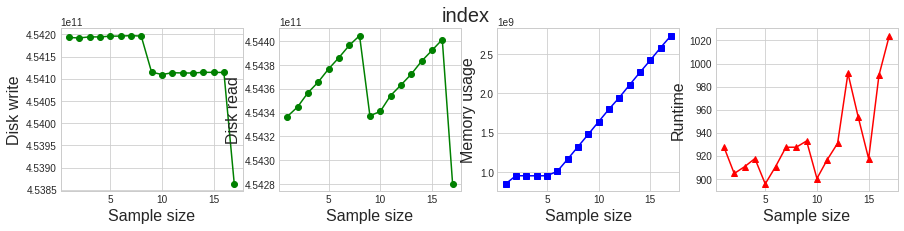

In [12]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 243212288.0, 'disk_read': 17485659.0, 'disk_write': 638594.0, 'runtime': 0.97}, {'memory': 244449280.0, 'disk_read': 17477933.0, 'disk_write': 637942.0, 'runtime': 0.95}, {'memory': 243347456.0, 'disk_read': 17476128.0, 'disk_write': 637773.0, 'runtime': 0.96}, {'memory': 243134464.0, 'disk_read': 17477623.0, 'disk_write': 637983.0, 'runtime': 0.95}, {'memory': 244334592.0, 'disk_read': 17476112.0, 'disk_write': 637761.0, 'runtime': 0.93}, {'memory': 244125696.0, 'disk_read': 17476249.0, 'disk_write': 637828.0, 'runtime': 0.95}, {'memory': 244256768.0, 'disk_read': 17474937.0, 'disk_write': 645903.0, 'runtime': 0.95}, {'memory': 242868224.0, 'disk_read': 17474947.0, 'disk_write': 637712.0, 'runtime': 0.92}, {'memory': 243908608.0, 'disk_read': 17475289.0, 'disk_write': 638046.0, 'runtime': 0.91}, {'memory': 244428800.0, 'disk_read': 17475288.0, 'disk_write': 638054.0, 'runtime': 0.92}, {'memory': 244027392.0, 'disk_read': 17475404.0, 'disk_write': 629915.0, 'runtime': 0.87}

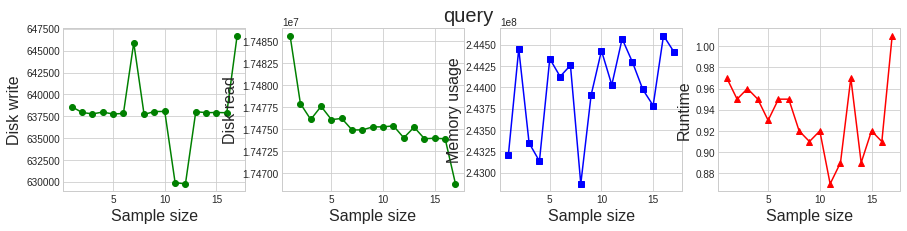

In [13]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")